<a href="https://colab.research.google.com/github/codewithAshwani/Text-to-Speech-Generation/blob/main/MNIST_Digit_text_To_sound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import numpy
from pickle import load
import tensorflow as tf
import IPython.display as ipd
import sklearn
from phonemizer import phonemize
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from Transformer import *
pickle_path_feature = '/feature_mel_all.pkl'

In [ ]:
####################################
# MelSpectogram Information
####################################

FRAME_SIZE = 1024
HOP_LENGTH = 200
DURATION = 0.8  # in seconds
SAMPLE_RATE = 22050
MEL_CHANNELS = 60
win_length  =  1011
max_db = 100
ref_db = 20
power = 0.5
start_vec = np.ones((1, MEL_CHANNELS))*0.5
end_vec = np.ones((1, MEL_CHANNELS))*(-0.1)

In [ ]:
####################################
# Load Spectogram
####################################

def load_features(filename):
    # load all features
    data = load(open(filename, 'rb'))

    datax = data["feauture_mfcc"]
    y = data["mapping"]
    phonem = data["phonem"]

    x_data = []
    for mel in datax:
        norm_mel = np.concatenate([start_vec, mel[::2,:], end_vec], axis=0)
        x_data.append(norm_mel)
        
    length = [x.shape[0] for x in x_data]
    
    pad_len = max([x.shape[0] for x in x_data])
    # padding to 2 seconds
    pad_arr = [np.pad(x, ((0, pad_len), (0, 0)), 'constant', constant_values=(0))[:pad_len, :] for x in x_data]

    
    return pad_arr,y, phonem, length
x_data,y_word, y, length = load_features(pickle_path_feature)

In [ ]:
####################################
# Convert text to phonem
####################################
def text_phonem(word):
  phon_sente = phonemize(word, language='en-us',
                             backend='espeak',
                             strip=True,
                             preserve_punctuation=True,
                             with_stress=True,
                             njobs=4,
                             language_switch='remove-flags')
  return phon_sente
#y = [text_phonem(y_word[i]) for i in range(len(y_word))] 

In [ ]:
####################################
#Example of phonem conversion
####################################
print(f'Phonem associated with word {y_word[0]} is {y[0]}')

Phonem associated with word eight is ˈeɪt


In [ ]:
# maximum length of label
max_length = max([len(label) for label in y])

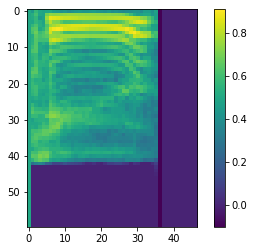

In [ ]:
####################################
#Example of Spectogram
####################################
x = np.array(x_data)
xy=np.reshape(x[1], (x[1].shape[0],x[1].shape[1]))
plt.imshow(xy.T)
plt.colorbar()
plt.show()

In [ ]:
####################################
# Characters from the sound word
####################################
characters = set(char for label in y for char in label)
start_token, end_token, pad_token = '>', '<','/'

In [ ]:
####################################
# Tokenize the phonem
####################################
num_to_char = {i: s for i, s in enumerate(characters, start=1)}
start_token_index = len(characters) + 1
end_token_index = len(characters) + 2
pad_token_index = 0
vocab_size = len(characters)+3
num_to_char[start_token_index] = start_token
num_to_char[end_token_index] = end_token
num_to_char[pad_token_index] = pad_token
char_to_num = {v:k for k,v in num_to_char.items()}

In [ ]:
# Tokenize the phonem
def tokenize(y):
    sentence = [char_to_num[c] for c in y]
    sequence = [start_token_index] + sentence + [end_token_index]
    while len(sequence)<(max_length+2):
      sequence.append(0)
    return sequence
y2=[tokenize(y[i]) for i in range(len(y))] 

In [ ]:
x=np.asarray(x)
x=np.reshape(x, (x.shape[0],x.shape[1],-1))
mel_channels = x.shape[2]
T_shape = x.shape[1]

In [ ]:
# Shuffle the data
x_train, y_train = sklearn.utils.shuffle(np.asarray(y2),np.asarray(x), random_state=42)

In [ ]:
x_train.shape, y_train.shape

((3000, 9), (3000, 47, 60))

In [ ]:
####################################
# DataLoader
####################################
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 64
steps_per_epoch = x_train.shape[0]//BATCH_SIZE
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
def masked_mean_squared_error(targets, logits):
    mse = tf.keras.losses.MeanSquaredError()
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int32)
    mask = tf.reduce_max(mask, axis=-1)
    loss = mse(targets, logits, sample_weight=mask)
    return loss

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_mel_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
num_layers = 8
d_model = 128
dff = 128*4
num_heads = 4
dropout_rate = 0.1
num_hid=1024
out_shape=mel_channels

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    embed_size=d_model,
    heads=num_heads,
    feed_forward=dff,
    input_vocab_size=vocab_size,
    target_vocab_size=mel_channels,
    dense_hidden_units = mel_channels*4,
    pe_input=100,
    pe_target=10000,
    rate=dropout_rate,
    num_hid = num_hid)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
@tf.function
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    mel, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss1 = masked_mean_squared_error(tar_real, mel)
    loss = loss1
  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  return loss

In [ ]:
EPOCHS =1000
history = {
  "epoch": [],
  "loss": []  
}
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0
#  train_loss.reset_states()
  for (batch, (inp, tar)) in enumerate(dataset):
    batch_loss = train_step(inp, tar)
    total_loss = total_loss+batch_loss
  history['epoch'].append(epoch)
  history['loss'].append(total_loss)
  if (epoch+1) % 1 == 0:    
    print(f'Epoch {epoch + 1} Loss {total_loss:.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')


Epoch 1 Loss 0.2009
Time taken for 1 epoch: 19.64 secs

Epoch 2 Loss 0.1988
Time taken for 1 epoch: 3.68 secs

Epoch 3 Loss 0.1983
Time taken for 1 epoch: 3.68 secs

Epoch 4 Loss 0.1985
Time taken for 1 epoch: 3.69 secs

Epoch 5 Loss 0.1969
Time taken for 1 epoch: 3.69 secs

Epoch 6 Loss 0.1959
Time taken for 1 epoch: 3.69 secs

Epoch 7 Loss 0.1953
Time taken for 1 epoch: 3.69 secs

Epoch 8 Loss 0.1939
Time taken for 1 epoch: 3.72 secs

Epoch 9 Loss 0.1931
Time taken for 1 epoch: 3.71 secs

Epoch 10 Loss 0.1932
Time taken for 1 epoch: 3.71 secs

Epoch 11 Loss 0.1913
Time taken for 1 epoch: 3.70 secs

Epoch 12 Loss 0.1898
Time taken for 1 epoch: 3.69 secs

Epoch 13 Loss 0.1912
Time taken for 1 epoch: 3.70 secs

Epoch 14 Loss 0.1890
Time taken for 1 epoch: 3.70 secs

Epoch 15 Loss 0.1892
Time taken for 1 epoch: 3.70 secs

Epoch 16 Loss 0.1877
Time taken for 1 epoch: 3.70 secs

Epoch 17 Loss 0.1878
Time taken for 1 epoch: 3.69 secs

Epoch 18 Loss 0.1865
Time taken for 1 epoch: 3.71 secs



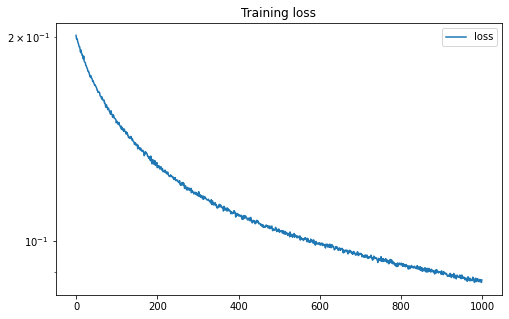

In [ ]:
####################################
# Loss Plot
####################################
plt.figure(figsize=(8,5))
plt.yscale("log")
plt.plot(history["epoch"],history["loss"], label='loss')
plt.title('Training loss')
plt.legend(loc='best')
plt.show()

In [ ]:
#####################################
# Evaluate the Spectogram form Phonem
#####################################
def evaluate(sentence):
  encoder_input = sentence

  start_vec = tf.zeros((1, mel_channels), dtype=tf.float32)
  end_vec = tf.zeros((1, mel_channels), dtype=tf.float32)
  #  encoder_input = tf.cast(tf.expand_dims(encoder_input, 0), tf.int32)
  output = tf.cast(tf.expand_dims(start_vec, 0), tf.float32)
  output_concat = tf.cast(tf.expand_dims(start_vec, 0), tf.float32)
  out_dict = {}
#  print(encoder_input.shape, output.shape)
  for i in range(T_shape):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    
    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

    # stop token
    if tf.reduce_sum(predictions, axis=-1) < 0:
      break
    output = tf.concat([output, predictions], axis=-2)
#    print(i,tf.reduce_sum(predictions, axis=-1))
  # output.shape (1, tokens)

  return output

In [ ]:
#####################################
# Using Griffin-Lim reconstruction to convert
# mel spectrogram back into a waveform.
#####################################
import copy
import librosa
def griffin_lim(spectrogram, rate=1):
    mel = np.transpose(spectrogram[1:-1,:])

        # de-noramlize
    mel = (np.clip(mel, 0, 1) * max_db) - max_db + ref_db

      # to amplitude
    spectrogram = np.power(10.0, mel * 0.05)
    S = librosa.feature.inverse.mel_to_stft(
            spectrogram,
            power=0.5,
            sr=SAMPLE_RATE,
            n_fft=FRAME_SIZE,
            fmin=0,
            fmax=None)
    S_slow = librosa.core.phase_vocoder(S, rate=rate, hop_length=HOP_LENGTH)

    y = librosa.griffinlim(
            S_slow,
            n_iter=32,
            hop_length=HOP_LENGTH,
            win_length=win_length)

    return y

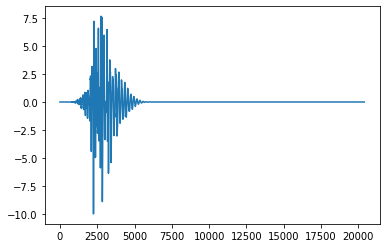

In [ ]:
#####################################
# Example
#####################################
sentence = 'two'
phonem = text_phonem(sentence)
inp = tokenize(phonem)
inp = np.array(inp)
inp = tf.expand_dims(inp, axis=0)
mel = evaluate(inp)
mel= np.reshape(mel, (mel.shape[1],mel.shape[2]))
# wav reconstruction
y = griffin_lim(mel, rate=0.45)
plt.plot(y);
ipd.display(ipd.Audio(y, rate=SAMPLE_RATE))

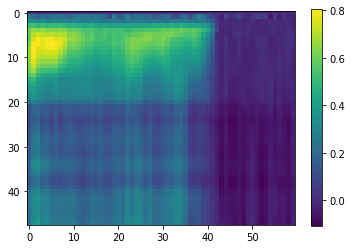

In [ ]:
plt.imshow(mel)
plt.colorbar()
plt.show()

In [ ]:
##############
# Example
##############
sentences = ['zero', 'one', 'two', 'three','four','five','six','seven','eight','nine']
for i,sentence in enumerate(sentences):
  phonem = text_phonem(sentence)
  inp = tokenize(phonem)
  inp = np.array(inp)
  inp = tf.expand_dims(inp, axis=0)
  mel = evaluate(inp)
  mel= np.reshape(mel, (mel.shape[1],mel.shape[2]))
  # wav reconstruction
  y = griffin_lim(mel, rate=0.45)
  ipd.display(ipd.Audio(y, rate=SAMPLE_RATE))
  print("   words : ", sentence)

   words :  zero


   words :  one


   words :  two


   words :  three


   words :  four


   words :  five


   words :  six


   words :  seven


   words :  eight


   words :  nine
